## Homework. Trees.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
import xgboost as xgb

RANDOM_STATE = 1

Read data

In [2]:
df = pd.read_csv('housing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Split to train, validate, test

In [3]:
df = df.fillna(0)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(f"train: {len(df_train)}, validate: {len(df_val)}, test: {len(df_test)}")

train: 12384, validate: 4128, test: 4128


Preprocess

In [4]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts= df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Question 1
Let's train a decision tree regressor to predict the median_house_value variable. Train a model with max_depth=1.

In [5]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



### Question 2
Train a random forest model with these parameters:
- n_estimators=10  
- random_state=1  
- n_jobs=-1 (optional - to make training faster)

In [6]:
rf = RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print(f"RMSE on validate: {np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)}")

RMSE on validate: 0.25


### Question 3
Now let's experiment with the n_estimators parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

In [7]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=RANDOM_STATE,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, score))

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


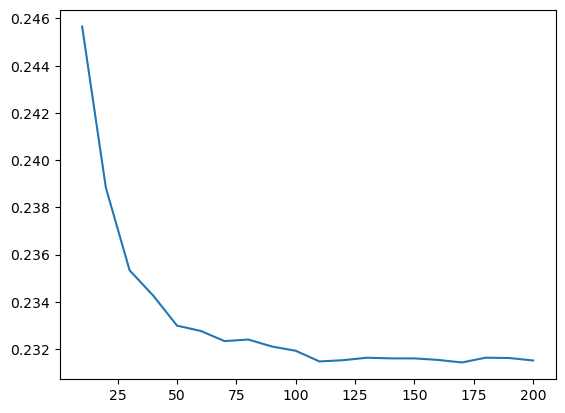

In [8]:
columns = ['n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

### Question 4
Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

In [9]:
scores = []

for depth in tqdm([10, 15, 20, 25]):
    for n in tqdm(range(10, 200+1, 10)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=depth,
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n, depth, score))

100%|██████████| 4/4 [00:58<00:00, 14.72s/it]


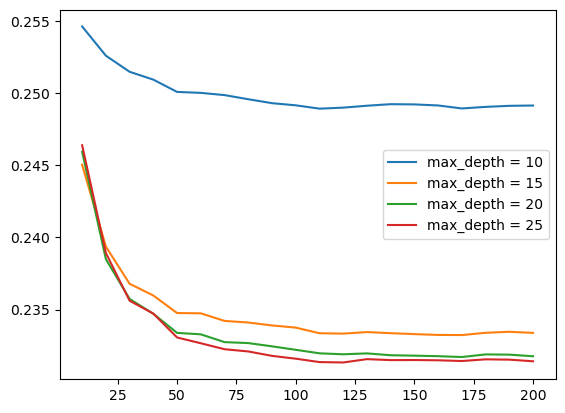

In [10]:
columns = ['n_estimators', 'max_depth', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')
    
plt.legend()
plt.show()

### Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)
Get the feature importance information from this model

In [11]:
scores= []

rf = RandomForestRegressor(n_estimators=10,
                           random_state=RANDOM_STATE,
                           max_depth=20,
                           n_jobs=-1)
rf.fit(X_train, y_train)

df_importances = pd.DataFrame({'feature': dv.get_feature_names_out(),
                               'importance': rf.feature_importances_
                               })
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR OCEAN,0.004699


### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:
- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
Train a model with these parameters for 100 rounds:

In [12]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [13]:
features = dv.get_feature_names_out()
features = list(map(lambda x: x.replace('<', 'LESS'), features))

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [14]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

scores = {}

In [16]:
%%capture output

UsageError: %%capture is a cell magic, but the cell body is empty.


In [17]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

scores['eta=0.3'] = parse_xgb_output(output)

In [18]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

scores['eta=0.1'] = parse_xgb_output(output)

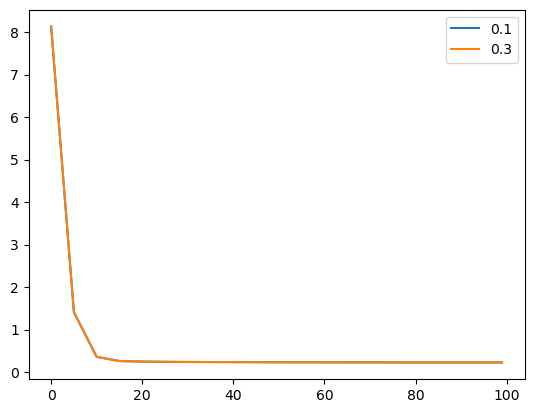

In [19]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()